In [1]:
import tensorflow as tf

print(tf.__version__, tf.config.list_physical_devices())

2025-03-20 00:10:24.214429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-20 00:10:24.238830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-20 00:10:24.247150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 00:10:24.265601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.17.0 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1742429427.392471   70799 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742429427.400849   70799 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742429427.400918   70799 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
from keras.datasets import mnist, boston_housing  # MNIST dataset
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras import models
from keras import layers
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import statistics
import pickle

In [3]:
# val_size_pointer = int(len(X_train)*0.2)
eps = 10
num_of_test = 5
activation_funcs = ["relu", "sigmoid", "softplus"]


def train_network(
    path: str,
    activation_funcs: list,
    input_lay,
    output_lay,
    loss_func: str,
    metrics: list[str],
    X_train,
    y_train,
    X_test,
    y_test,
):
    logs = dict()
    for activation_func in activation_funcs:
        for test_time in range(num_of_test):
            log_id = f"{activation_func}_t{test_time}"
            network = models.Sequential(
                [
                    input_lay,
                    layers.Dense(512, activation=activation_func),
                    layers.Dense(256, activation=activation_func),
                    layers.Dense(128, activation=activation_func),
                    output_lay,
                ]
            )
            network.compile(optimizer="adam", loss=loss_func, metrics=metrics)

            cp = ModelCheckpoint(
                filepath=f"{path}/{log_id}.weights.h5",
                monitor="val_loss",
                save_best_only=True,
                save_weights_only=True,
            )
            his = network.fit(
                X_train,
                y_train,
                epochs=eps,
                batch_size=128,
                validation_split=0.2,
                verbose=0,
                callbacks=[cp],
            )
            network.load_weights(f"{path}/{log_id}.weights.h5")
            test_logs = network.evaluate(X_test, y_test, verbose=0, return_dict=True)
            logs[log_id] = his.history
            for key in test_logs.keys():
                logs[log_id][f"test_{key}"] = test_logs[key]
    return logs

## MNIST

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape((-1, 28 * 28)).astype("float32") / 255
X_test = X_test.reshape((-1, 28 * 28)).astype("float32") / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
logs = train_network(
    "./weights/Q2/mnist",
    activation_funcs,
    layers.Input(shape=(28 * 28,)),
    layers.Dense(10, activation="softmax"),
    "categorical_crossentropy",
    ["accuracy"],
    X_train,
    y_train,
    X_test,
    y_test,
)
pickle.dump(logs, open("q2_mnist_logs.pkl", "wb"))

In [ ]:
logs = pickle.load(open("q2_mnist_logs.pkl", "rb"))
logs_df = pd.DataFrame(logs).T
logs_df = logs_df.reset_index()
logs_df["activation_func"] = logs_df["index"].apply(lambda x: x.split("_")[0])

In [ ]:
logs_df.groupby("activation_func")[
    ["test_loss", "test_accuracy"]
].mean()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 繪製 ReLU 的準確率圖
train_acc = logs["relu_t0"]['accuracy']
val_acc = logs["relu_t0"]['val_accuracy']
epochs_range = range(1, len(train_acc) + 1)
axes[0].plot(epochs_range, train_acc, 'bo-', label="Training Accuracy (ReLU)")
axes[0].plot(epochs_range, val_acc, 'r^-', label="Validation Accuracy (ReLU)")
axes[0].set_title("Training and Validation Accuracy (ReLU)")
axes[0].set_xlabel("Epochs")
axes[0].legend()
axes[0].grid(True)

# 繪製 Sigmoid 的準確率圖
train_acc = logs["sigmoid_t0"]['accuracy']
val_acc = logs["sigmoid_t0"]['val_accuracy']
epochs_range = range(1, len(train_acc) + 1)
axes[1].plot(epochs_range, train_acc, 'bo-', label="Training Accuracy (Sigmoid)")
axes[1].plot(epochs_range, val_acc, 'r^-', label="Validation Accuracy (Sigmoid)")
axes[1].set_title("Training and Validation Accuracy (Sigmoid)")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True)

# 繪製 Softplus 的準確率圖
train_acc = logs["softplus_t0"]['accuracy']
val_acc = logs["softplus_t0"]['val_accuracy']
epochs_range = range(1, len(train_acc) + 1)
axes[2].plot(epochs_range, train_acc, 'bo-', label="Training Accuracy (Softplus)")
axes[2].plot(epochs_range, val_acc, 'r^-', label="Validation Accuracy (Softplus)")
axes[2].set_title("Training and Validation Accuracy (Softplus)")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Accuracy")
axes[2].legend()
axes[2].grid(True)

# 顯示圖表
plt.tight_layout()
plt.show()


## boston_housing

In [ ]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

m = X_train.mean(axis=0)
s = X_train.std(axis=0)

X_train -= m
X_train /= s

X_test -= m
X_test /= s

In [ ]:
logs = train_network(
    "./weights/Q2/boston",
    activation_funcs,
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(1),
    "mean_squared_error",
    [
        "mean_absolute_error",
        "root_mean_squared_error",
        "mean_absolute_percentage_error",
    ],
    X_train,
    y_train,
    X_test,
    y_test,
)
pickle.dump(logs, open("q2_boston_housing_logs.pkl", "wb"))

In [4]:
logs = pickle.load(open("q2_boston_housing_logs.pkl", "rb"))
logs_df = pd.DataFrame(logs).T
logs_df = logs_df.reset_index()
logs_df["activation_func"] = logs_df["index"].apply(lambda x: x.split("_")[0])

In [5]:
logs_df.groupby("activation_func")[
    ["test_loss", "test_mean_absolute_error", "test_mean_absolute_percentage_error", "test_root_mean_squared_error"]
].mean()

,test_loss,test_mean_absolute_error,test_mean_absolute_percentage_error,test_root_mean_squared_error
activation_func,,,,
relu,83.27336,7.117827,40.543922,9.096297
sigmoid,135.743828,8.942332,39.207161,11.571029
softplus,49.373488,5.147556,28.446291,7.010781


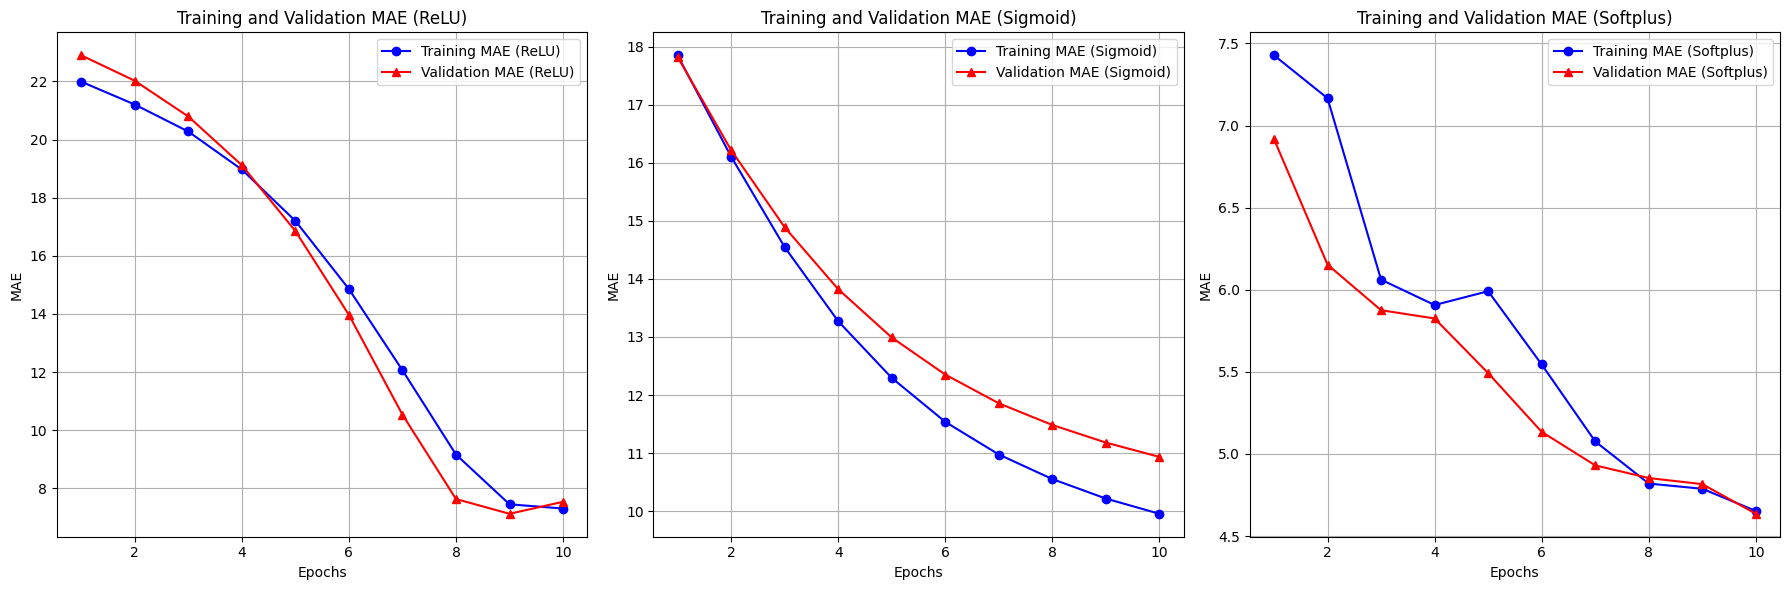

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 繪製 ReLU 的準確率圖
train_mae = logs["relu_t0"]['mean_absolute_error']
val_mae = logs["relu_t0"]['val_mean_absolute_error']
epochs_range = range(1, len(train_mae) + 1)
axes[0].plot(epochs_range, train_mae, 'bo-', label="Training MAE (ReLU)")
axes[0].plot(epochs_range, val_mae, 'r^-', label="Validation MAE (ReLU)")
axes[0].set_title("Training and Validation MAE (ReLU)")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("MAE")
axes[0].legend()
axes[0].grid(True)

# 繪製 Sigmoid 的準確率圖
train_mae = logs["sigmoid_t0"]['mean_absolute_error']
val_mae = logs["sigmoid_t0"]['val_mean_absolute_error']
epochs_range = range(1, len(train_mae) + 1)
axes[1].plot(epochs_range, train_mae, 'bo-', label="Training MAE (Sigmoid)")
axes[1].plot(epochs_range, val_mae, 'r^-', label="Validation MAE (Sigmoid)")
axes[1].set_title("Training and Validation MAE (Sigmoid)")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("MAE")
axes[1].legend()
axes[1].grid(True)

# 繪製 Softplus 的準確率圖
train_mae = logs["softplus_t0"]['mean_absolute_error']
val_mae = logs["softplus_t0"]['val_mean_absolute_error']
epochs_range = range(1, len(train_mae) + 1)
axes[2].plot(epochs_range, train_mae, 'bo-', label="Training MAE (Softplus)")
axes[2].plot(epochs_range, val_mae, 'r^-', label="Validation MAE (Softplus)")
axes[2].set_title("Training and Validation MAE (Softplus)")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("MAE")
axes[2].legend()
axes[2].grid(True)

# 顯示圖表
plt.tight_layout()
plt.show()